In [7]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [8]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [9]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [10]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [11]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.698e-02 ...  4.989e+03  5.000e+03]
        y: [[ 1.000e+02  1.001e+02 ...  6.308e+01  6.877e+01]
            [ 1.000e+00  1.253e+00 ...  3.343e+01  3.945e+01]
            ...
            [ 1.000e+00  9.988e-01 ... -7.076e-07 -1.458e-07]
            [ 1.000e+00  9.997e-01 ...  6.556e-07  1.346e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4148
     njev: 0
      nlu: 0


In [12]:
time_transient, p_transient, m_transient, Mf_transient, Mb_transient, n_transient = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

[]

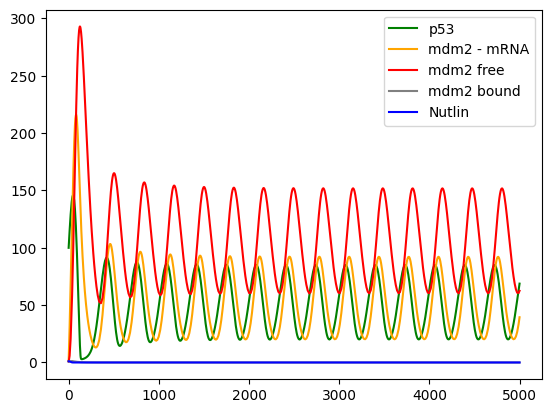

In [13]:
plt.plot(time_transient, p_transient, color="green", label="p53")
plt.plot(time_transient, m_transient, color="orange", label="mdm2 - mRNA")
plt.plot(time_transient, Mf_transient, color="red", label="mdm2 free")
plt.plot(time_transient, Mb_transient, color="gray", label="mdm2 bound")
plt.plot(time_transient, n_transient, color="blue", label="Nutlin")


plt.legend()
plt.plot()

# Peakfinding på transient

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

In [37]:
# Compute stats for p53 transient to find period and amplitude for nutlin simulation
def compute_external_oscillator(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [38]:
T_int, A_int, mean_int, stable_peaks_int, stable_troughs_int = compute_external_oscillator(time_transient, p_transient)

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

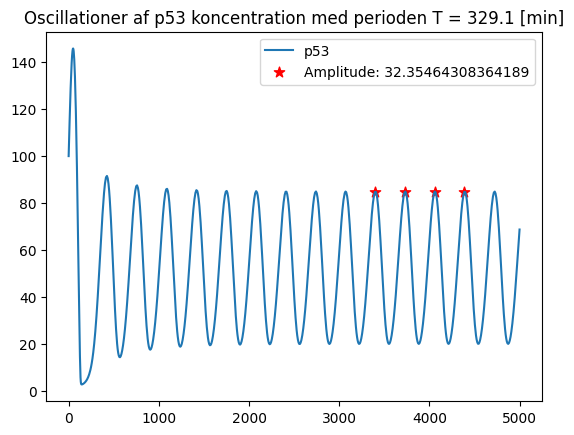

In [39]:
plt.plot(time_transient, p_transient, label="p53")
plt.scatter(time_transient[stable_peaks_int], p_transient[stable_peaks_int], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

In [40]:
def sim_onoff_nutlin(oscillationer, T_int, OOmega, p0, m0, Mf0, Mb0, A_ext):
    # This is correct, and it is working! Remember to count in period values, not frequency! If you count in frequency, you are counting the reciprocal.
    T_ext = OOmega * T_int
    omega = T_int / T_ext

    history = {"t":[] ,"p": [], "m": [], "Mf": [], "Mb":[], "n":[]}

    # TODO: Undersøg max_step i fremtiden
    for i in range(oscillationer):
        if i == 0:
            state = p0, m0, Mf0, Mb0, A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].extend(t)
            history["p"].extend(p)
            history["m"].extend(m)
            history["Mf"].extend(Mf)
            history["Mb"].extend(Mb)
            history["n"].extend(n)
        
        # Every period, Nutlin concentration is reset to A_ext
        state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
        sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45', max_step=5, dense_output=True)
        t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
        history["t"].extend(t + history["t"][-1])
        history["p"].extend(p)
        history["m"].extend(m)
        history["Mf"].extend(Mf)
        history["Mb"].extend(Mb)
        history["n"].extend(n)
    
    return history, omega, T_ext

# Simulér med nutlin

In [41]:
current_omega = 1.5
Nutlin_A = A_int*3

In [42]:
nutlin_sim1, omega, T_ext_sim1 = sim_onoff_nutlin(50, T_int, current_omega, p_transient[-1], m_transient[-1], Mf_transient[-1], Mb_transient[-1], Nutlin_A)

In [43]:
t_1, p_1, m_1, Mb_1, Mf_1, n_1 = np.array(nutlin_sim1["t"]), np.round(np.array(nutlin_sim1["p"]), 4), np.round(np.array(nutlin_sim1["m"]), 4), np.round(np.array(nutlin_sim1["Mb"]), 4), np.round(np.array(nutlin_sim1["Mf"]), 4), np.round(np.array(nutlin_sim1["n"]), 4)

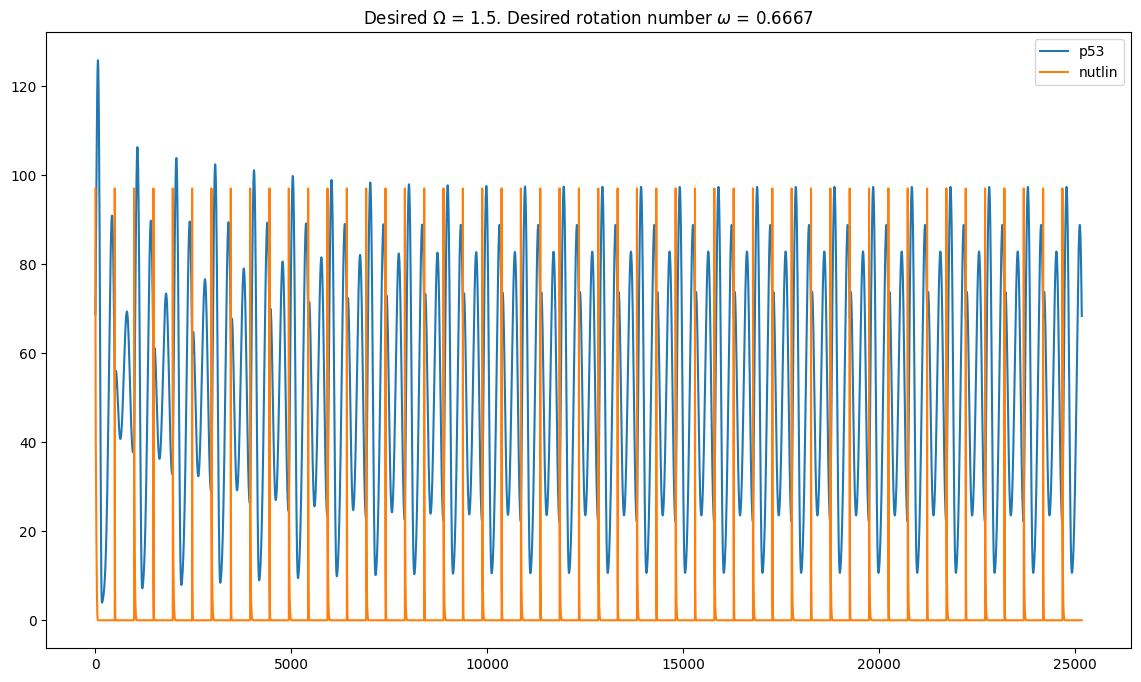

In [97]:
plt.figure(figsize=(14, 8))

plt.plot(t_1, p_1, label="p53")
plt.plot(t_1, n_1, label="nutlin")
# plt.plot(t_1, m_1, label="mRNA")
# plt.plot(t_1, Mb_1, label="Mb")
# plt.plot(t_1, Mf_1, label="Mf")

plt.title(rf"Desired $\Omega$ = {current_omega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()

# plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.4} [min]")

[]

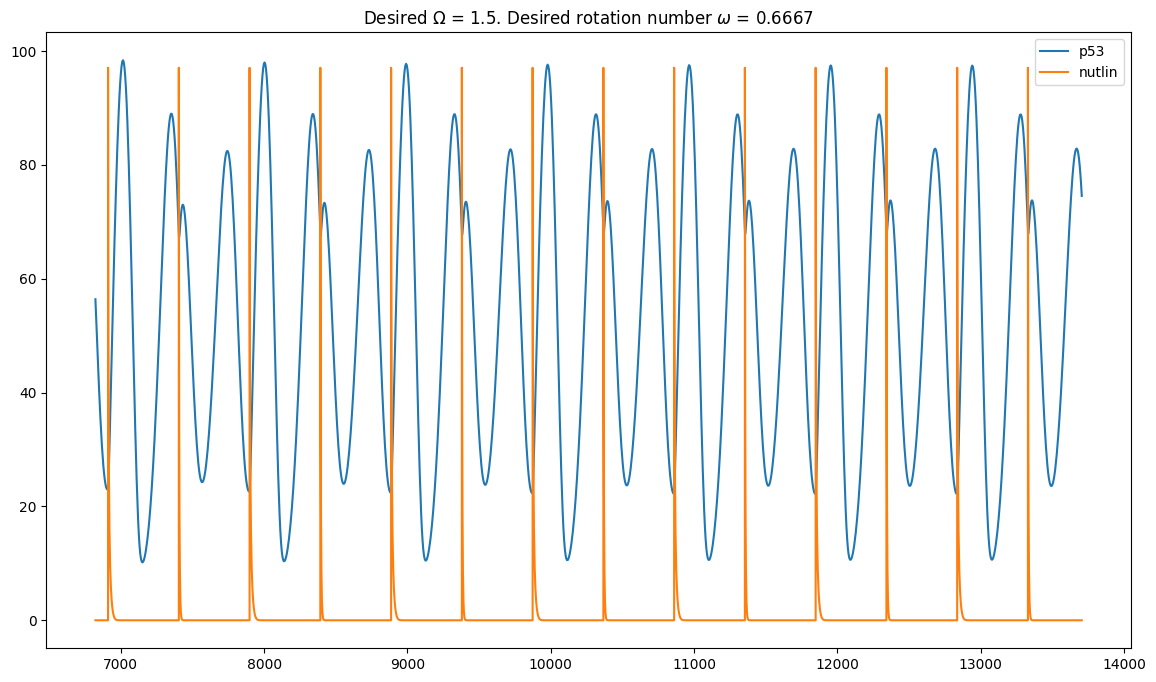

In [99]:
plt.figure(figsize=(14, 8))

plt.plot(t_1[1500:3000], p_1[1500:3000], label="p53")
plt.plot(t_1[1500:3000], n_1[1500:3000], label="nutlin")

# for i in range(len(peaks_nutlin)):
#     plt.scatter(t_1[peaks_nutlin[i]], n_1[peaks_nutlin[i]], c="red", marker='*')

# for i in range(len(troughs_p53)):
#     plt.scatter(t_1[troughs_p53[i]], p_1[troughs_p53[i]], c="black", marker='*')

plt.title(rf"Desired $\Omega$ = {current_omega}. Desired rotation number $\omega$ = {omega:.4}")

plt.legend()
plt.plot()

In [44]:
_, _, _, peaks_p53_after_transient, _ = compute_external_oscillator(np.array(t_1), np.array(p_1))

[]

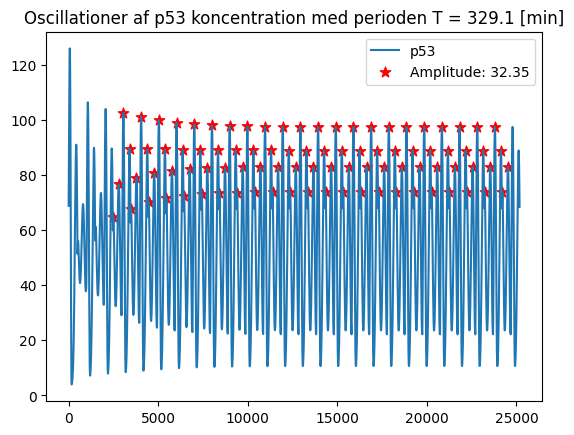

In [96]:
plt.plot(t_1, p_1, label="p53")
plt.scatter(t_1[peaks_p53_after_transient], p_1[peaks_p53_after_transient], s=60, c="red", marker='*', label=f"Amplitude: {A_int:.4}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")
plt.plot()

# Isolér højeste peaks i nutlin sim
Nedenstående er et forsøg på at klassificere entrainment hvor vi kun kigger på de højeste peaks. Men det er svært at isolere peaks'ne consistent uden at miste information.

In [77]:
# Running this after starting nutlin
# For finding a candidate for peak height of highest peaks.
def get_peak_height(y):
    y_peaks = find_peaks(y, height=None)[0][20:40]
    reference_height = 0

    for peak in y_peaks:
        if y[peak] > reference_height:
            reference_height = y[peak]
        else:
            continue
        
    return y_peaks, reference_height

In [78]:
highest_peak_candidates, height_interval = get_peak_height(p_1)

In [85]:
# Use "get_peak_height" after running nutlin sim to get a feeling for where the highest peaks are after adding nutlin
def find_highest_peaks_nutlin(y, reference_height):
    height_interval = [reference_height * 0.93, reference_height * 1.07]

    y_peaks = find_peaks(y, height=height_interval)[0]

    return y_peaks

In [86]:
top_peaks_after_adding_nutlin = find_highest_peaks_nutlin(p_1, height_interval)

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 329.1 [min]')

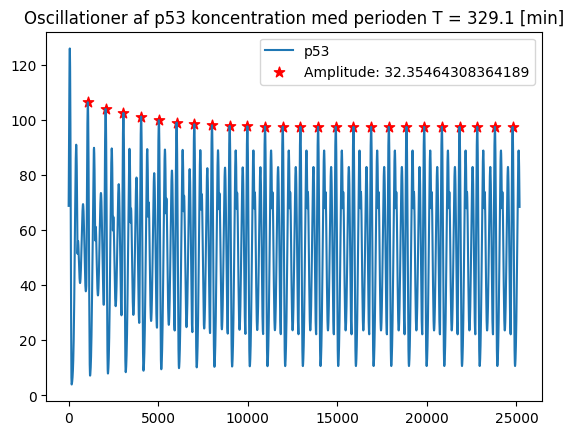

In [87]:
plt.plot(t_1, p_1, label="p53")
plt.scatter(t_1[top_peaks_after_adding_nutlin], p_1[top_peaks_after_adding_nutlin], s=60, c="red", marker='*', label=f"Amplitude: {A_int}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {T_int:.4} [min]")

In [90]:
def check_period_convergence(t, peaks):
    period_spacing = np.diff(np.diff(t[peaks]))
    return period_spacing

In [92]:
period_convergence = check_period_convergence(t_1, top_peaks_after_adding_nutlin)

In [93]:
x_dummy = np.arange(len(period_convergence))

Text(0.5, 1.0, 'Variation i periode?')

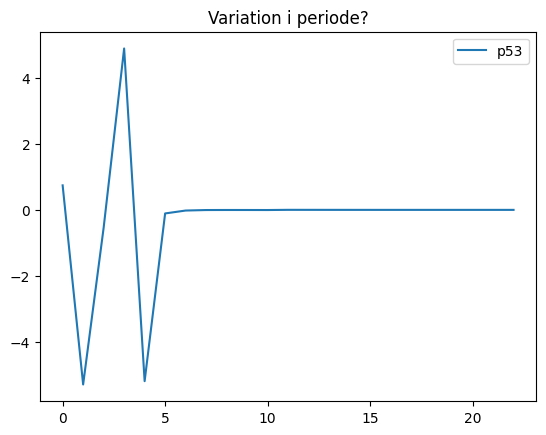

In [94]:
plt.plot(x_dummy, period_convergence, label=r"p53")

plt.legend()

plt.title(f"Variation i periode?")

# Behold mange peaks med nutlin og prøv at kigge på konvergens af alle "serier"